# STAT 301 Group 5 Final Report
## "Drivers of Marketing Campaign Response: A Customer Analysis"

---

#### Group Members:
- Nelson Li (32900045)
- Chriscenci Susanto (17538422)
- Yao Xiao
- Nariman Avakoli

## Introduction

Understanding which types of customers are more likely to engage with marketing campaigns is a importatn question in consumer analytics. Businesses invest substantial resources into customer research to help guide campaign targeting, yet it is not always clear which factors are most strongly associated with customer engagement. The [Customer Personality Analysis Dataset](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data) provides rich demographic and behavioural information which can be used to explore these associations in a statistical way.

In this project, we analyze a marketing campaign dataset containing information on customer demographics, past purchasing behaviour, and previous campaign participation. Our goal is to investigate how these characteristics relate to the likelihood of responding to the company's most recent marketing campaign. Since the data come from an observational setting, our focus is on identifying associations, rather than drawing causal conclusions about the effect of any variable on campaign response.

To guide our analysis, we consider the broad question:

> **What customer characteristics (demograpahic information, purchasing  behaviour, and past campaign engagement) are associated with responding to the company's most recent marketing campaign?**

Addressing this question requires fitting multipe logistic regression models using a common binary response variable (`Repsonse`) and a set of demographic and behavioural covariates. Since the primary goal of this analysis is inference, we seek to understand which characteristics show statistically significant associations with campaign response. These insight can support bussiness in making data-driven marketing decisions.

## Method & Results

### Data

#### Dataset Summary

The [Customer Personality Analysis Dataset](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data) from Kaggle contains demographic, behavioural and spending information about customers. It helps a business better understand its target customers and helps them modify their business strategies according to their specific needs, behaviours and converns of differnet types of customers.

- Number of observations: 2240 customers
- Number of variables: 29 variables
    - Variables consist of quantitative and categorical data relating to the customer profiles, products, and the ad campaigns.
- Unique Identifier: `ID`

#### Attribute Table
| Attribute Name | Attribute Grouping | **Data Type** | Variable Type |                            Description                            |
|:--------------:|:------------------:|:--------------:|:--------------:|:-----------------------------------------------------------------:|
| `ID` |       People       | integer |  **continuous** |                   Customer's Unique Identifier                   |
| `Year_Birth` |       People       | integer |    **continuous**  |                    Customer's Birth Year                       |
| `Education` |       People       | object |    **categorical** |                  Customer's education level                    |
| `Marital_Status` |       People       | object |  **categorical**  |                    Customer's marital status                     |
| `Income` |       People       | float |  **continuous** |               Customer's yearly household income                |
| `Kidhome` |       People       | float |**discrete/categorical** |             Number of children in customer's household            |
| `Teenhome` |       People       | float |    **discrete/categorical**|        Number of teenagers in customer's household            |
| `Dt_Customer` |       People       | float |    **date** |        Date of customer's enrollment with the company          |
| `Recency` |       People       | float |  **continuous**  |          Number of days since customer's last purchase           |
| `Complain` |       People       | float |  **categorical**  |  1 if the customer complained in the last 2 years, 0 otherwise   |
| `MntWines` |      Products      | integer |     **continuous**  |            Amount spent on wine in last 2 years               |
| `MntFruits` |      Products      | integer |    **continuous**  |            Amount spent on fruits in last 2 years              |
| `MntMeatProducts` |      Products      | integer |    **continuous**  |             Amount spent on meat in last 2 years               |
| `MntFishProducts` |      Products      | integer |     **continuous**  |            Amount spent on fish in last 2 years               |
| `MntSweetProducts` |      Products      | integer |    **continuous**  |            Amount spent on sweets in last 2 years              |
| `MntGoldProds` |      Products      | integer |        **continuous**  |         Amount spent on gold in last 2 years               |
| `NumDealsPurchases` |     Promotion      | integer |  **discrete/categorical** |            Number of purchases made with a discount             |
| `AcceptedCmp1` |     Promotion      | integer | **categorical**  | 1 if customer accepted the offer in the 1st campaign, 0 otherwise |
| `AcceptedCmp2` |     Promotion      | integer | **categorical**  | 1 if customer accepted the offer in the 2nd campaign, 0 otherwise |
| `AcceptedCmp3` |     Promotion      | integer | **categorical**  | 1 if customer accepted the offer in the 3rd campaign, 0 otherwise |
| `AcceptedCmp4` |     Promotion      | integer | **categorical**  | 1 if customer accepted the offer in the 4th campaign, 0 otherwise |
| `AcceptedCmp5` |     Promotion      | integer | **categorical**  | 1 if customer accepted the offer in the 5th campaign, 0 otherwise |
| `Response` |     Promotion      | integer |**categorical**  |  1 if customer accepted the offer in the last campaign, 0 otherwise |
| `NumWebPurchases` |       Place        | integer |  **discrete/categorical** |    Number of purchases made through the company’s website      |
| `NumCatalogPurchases` |       Place        | integer |   **discrete/categorical**|          Number of purchases made using a catalogue            |
| `NumStorePurchases` |       Place        | integer |  **discrete/categorical** |          Number of purchases made directly in stores            |
| `NumWebVisitsMonth` |       Place        | integer |  **discrete/categorical** |     Number of visits to company’s website in the last month      |
| `Z_CostContact` |       Misc.        | integer |      **-**  |                  No information given                        |
| `Z_Revenue` |       Misc.        | integer |             **-** |                 No information given                        |



#### Source & Information

- Source: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data (created by user `imakash3011`)

#### Pre-selection of variables

**Variables to be dropped**

- `ID` - this is a unique identifier and has no underlying relationship to model
- `Z_CostContact`, `Z_Revenue` - have the same value in all data points. So these two columns are not relevant and can be dropped
- `Dt_Customer` - date may not be very useful here especially since `Recency` might be collinear with it

In [3]:
# Loading in libraries
library(tidyverse)
library(broom)

In [4]:
# Reading in data (stored on github)
url <- "https://raw.githubusercontent.com/nelsonli2323/STAT-301-Project/refs/heads/main/marketing_campaign.csv"
customer_data <- read.delim(url, header = TRUE, sep = "\t")

glimpse(customer_data)

Rows: 2,240
Columns: 29
$ ID                  <int> 5524, 2174, 4141, 6182, 5324, 7446, 965, 6177, 485…
$ Year_Birth          <int> 1957, 1954, 1965, 1984, 1981, 1967, 1971, 1985, 19…
$ Education           <chr> "Graduation", "Graduation", "Graduation", "Graduat…
$ Marital_Status      <chr> "Single", "Single", "Together", "Together", "Marri…
$ Income              <int> 58138, 46344, 71613, 26646, 58293, 62513, 55635, 3…
$ Kidhome             <int> 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,…
$ Teenhome            <int> 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,…
$ Dt_Customer         <chr> "04-09-2012", "08-03-2014", "21-08-2013", "10-02-2…
$ Recency             <int> 58, 38, 26, 26, 94, 16, 34, 32, 19, 68, 11, 59, 82…
$ MntWines            <int> 635, 11, 426, 11, 173, 520, 235, 76, 14, 28, 5, 6,…
$ MntFruits           <int> 88, 1, 49, 4, 43, 42, 65, 10, 0, 0, 5, 16, 61, 2, …
$ MntMeatProducts     <int> 546, 6, 127, 20, 118, 98, 164, 56, 24, 6, 6, 11, 4…
$ MntFishProduct

### Exploratory Data Analysis

#### Cleaning Data

In [12]:
# Count NA values in each column
na_summary <- customer_data %>%
    summarise(across(everything(), ~sum(is.na(.)))) %>%
    pivot_longer(everything(), names_to = "Variable", values_to = "NA_Count") %>%
    filter(NA_Count > 0)

na_summary

Variable,NA_Count
<chr>,<int>
Income,24


The `Income` variable has 24 missing values (`NA`). We will remove those rows from the dataframe, factorize binary columns, and transform the following variables:

1. `Age` (years) - transformed from `Year_Birth` for interpretability
2. `Total_Spend` ($) - the sum of amount spent on fruits, meat, fish, sweet, and gold
3. `Total_AcceptedCmp` (count) - number of times customer accepted campaigns (integer from 0 to 5)

In [11]:
# Cleaning data, variable transformation, removing unnecessary columns
current_date <- Sys.Date()
current_year <- as.integer(format(current_date, "%Y"))

customer_data_clean <- customer_data %>%
    mutate(
        Age = current_year - Year_Birth,
        Total_Spend = MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds,
        Total_AcceptedCmp = AcceptedCmp1 + AcceptedCmp2 + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5,
        Education = as.factor(Education),
        Marital_Status = as.factor(Marital_Status),
        Dt_Customer = as.Date(Dt_Customer, format = "%d-%m-%Y"),
        Response = as.factor(Response),
        Complain = as.factor(Complain),
        AcceptedCmp1 = as.factor(AcceptedCmp1),
        AcceptedCmp2 = as.factor(AcceptedCmp2),
        AcceptedCmp3 = as.factor(AcceptedCmp3),
        AcceptedCmp4 = as.factor(AcceptedCmp4),
        AcceptedCmp5 = as.factor(AcceptedCmp5)
    ) %>%
    select(-ID, -Z_CostContact, -Z_Revenue) %>%
    filter(!if_any(everything(), is.na))

glimpse(customer_data_clean)

Rows: 2,216
Columns: 29
$ Year_Birth          <int> 1957, 1954, 1965, 1984, 1981, 1967, 1971, 1985, 19…
$ Education           <fct> Graduation, Graduation, Graduation, Graduation, Ph…
$ Marital_Status      <fct> Single, Single, Together, Together, Married, Toget…
$ Income              <int> 58138, 46344, 71613, 26646, 58293, 62513, 55635, 3…
$ Kidhome             <int> 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,…
$ Teenhome            <int> 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,…
$ Dt_Customer         <date> 2012-09-04, 2014-03-08, 2013-08-21, 2014-02-10, 2…
$ Recency             <int> 58, 38, 26, 26, 94, 16, 34, 32, 19, 68, 59, 82, 53…
$ MntWines            <int> 635, 11, 426, 11, 173, 520, 235, 76, 14, 28, 6, 19…
$ MntFruits           <int> 88, 1, 49, 4, 43, 42, 65, 10, 0, 0, 16, 61, 2, 14,…
$ MntMeatProducts     <int> 546, 6, 127, 20, 118, 98, 164, 56, 24, 6, 11, 480,…
$ MntFishProducts     <int> 172, 2, 111, 10, 46, 0, 50, 3, 3, 1, 11, 225, 3, 6…
$ MntSweetProduc

#### Visualizations

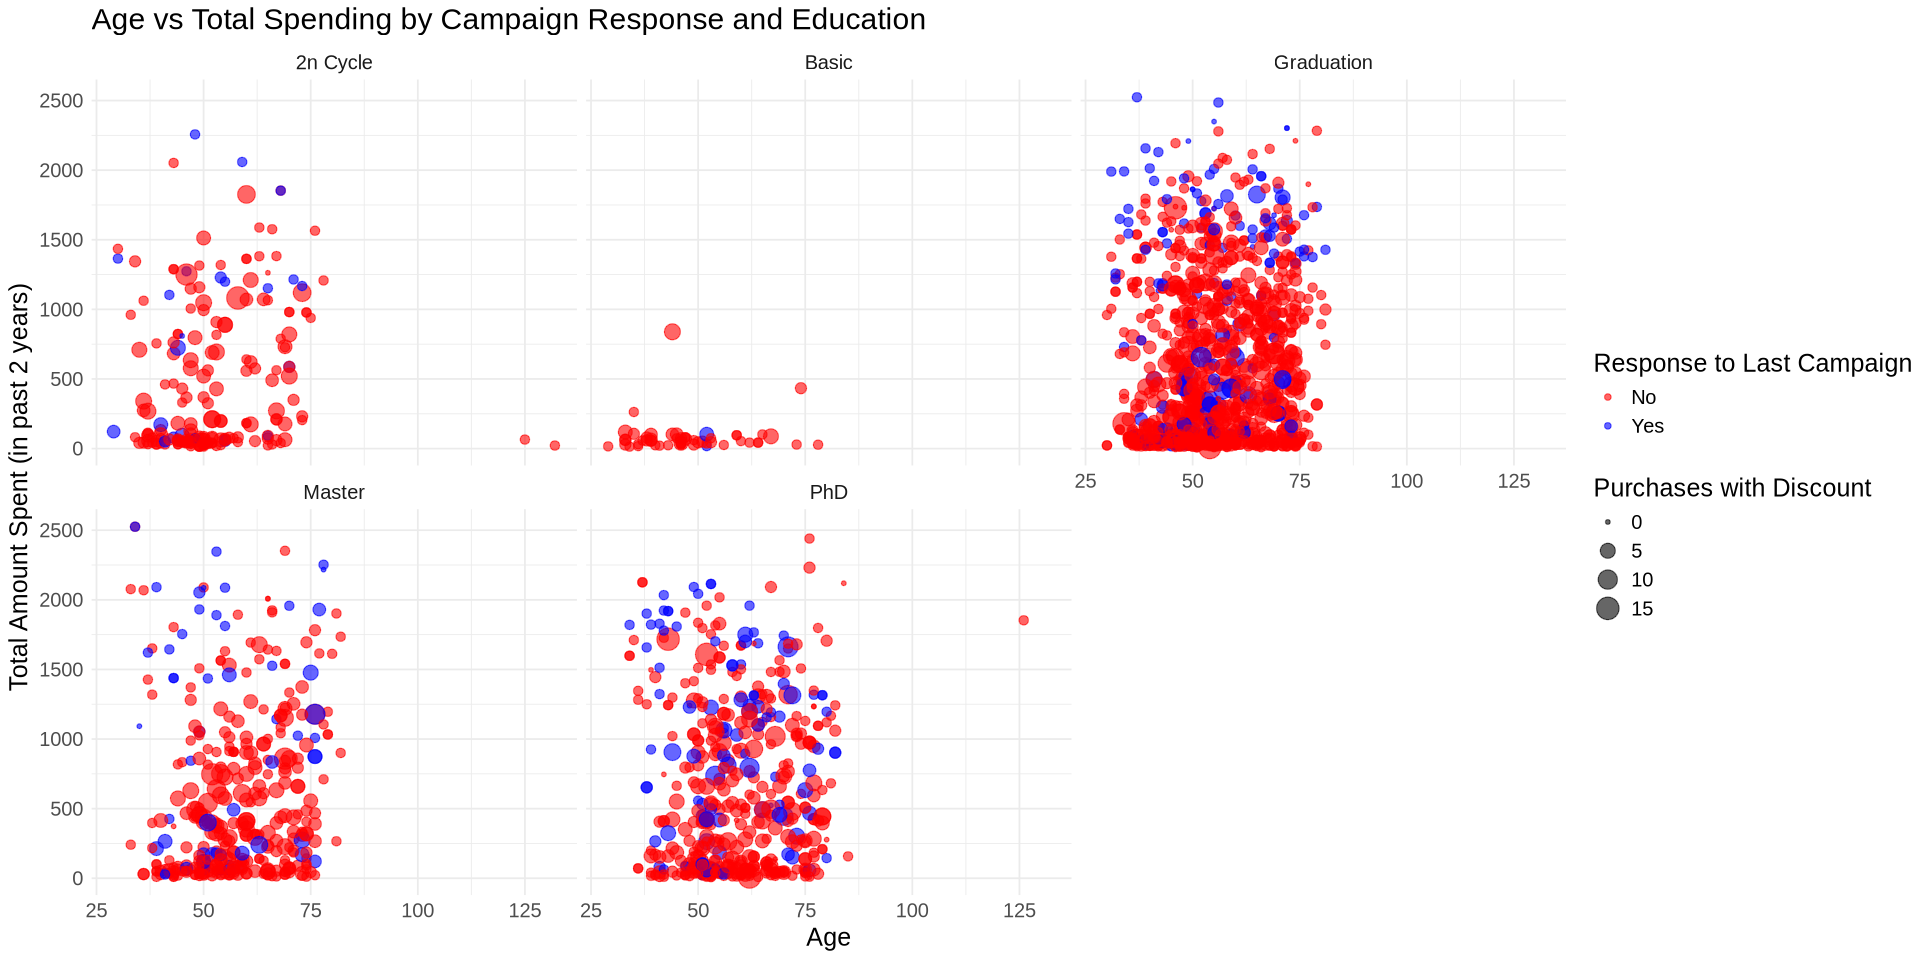

In [7]:
# Visualization 1
options(repr.plot.width = 16, repr.plot.height = 8)

customer_data_clean %>%
    ggplot(aes(x = Age, y = Total_Spend, colour = Response, size = NumDealsPurchases)) +
    geom_point(alpha = 0.6) +
    facet_wrap(~Education) +
    scale_color_manual(
        values = c("0" = "red", "1" = "blue"),
        labels = c("0" = "No", "1" = "Yes")
    ) +
    labs(
        title = "Age vs Total Spending by Campaign Response and Education",
        x = "Age",
        y = "Total Amount Spent (in past 2 years)",
        colour = "Response to Last Campaign",
        size = "Purchases with Discount"
    ) +
    theme_minimal() + 
    theme(text = element_text(size = 15))

The plot above examines the relationship between `Age`, `Total_Spend` and discound purchase behaviour (`NumDealsPurchased`) faceted by `Education` and coloured by the most recent campaign `Response`.

The visualization reveals that age does not show a strong relationship with total spending across education levels. Customers who responded to the most recent campaign (blue points) are generally found in the mid-to-high spending ranges, particularly among those with Graduation, Master, or PhD education levels. Larger points (more discount purchases) tend to cluster at the low-to-mid spending levels, suggesting that frequent use of discounts does not necessarily indicate high overall spending.

Overall, this plot suggests that higher education and higher total spending are associated with greater likelihood of responding to campaigns.

In [10]:
# Visualization 2
# TODO

**TODO** Interpretation for visualization 2

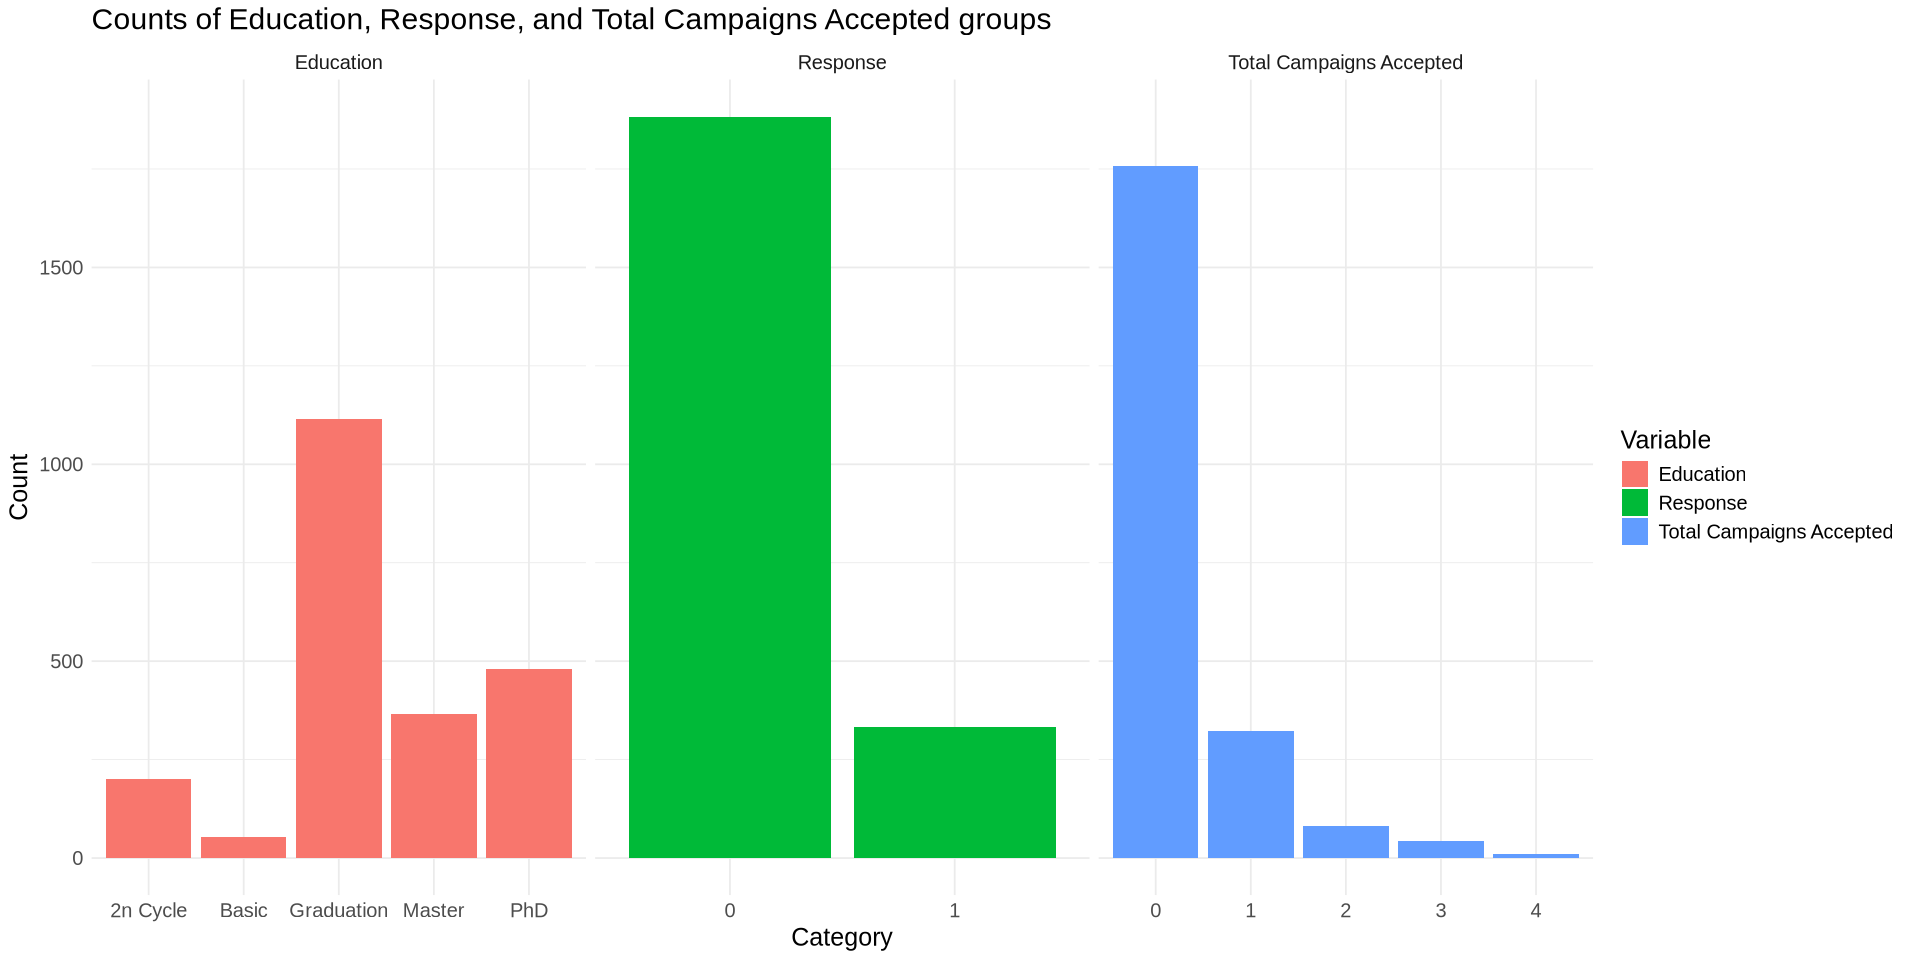

In [8]:
options(repr.plot.width = 16, repr.plot.height = 8)

# Helper function to create standardized summary tables
create_summary_table <- function(var_name, variable_label) {
  customer_data_clean %>%
    group_by({{ var_name }}) %>%
    summarize(Count = n()) %>%
    rename(Category = {{ var_name }}) %>%
    mutate(Variable = variable_label, Category = as.factor(Category))
}

# Create plotting data
response_table <- create_summary_table(Response, "Response")
education_table <- create_summary_table(Education, "Education")
accepted_table <- create_summary_table(Total_AcceptedCmp, "Total Campaigns Accepted")

plot_data_long <- bind_rows(response_table, education_table, accepted_table)

plot_data_long %>%
    ggplot(aes(x = Category, y = Count, fill = Variable)) +
    geom_bar(stat = "identity") +
    facet_wrap(~Variable, scales = "free_x") +
    labs(title = "Counts of Education, Response, and Total Campaigns Accepted groups") +
    theme_minimal() +
    theme(text = element_text(size = 15))

The plot above displays the distribution of three key variables: `Response`, `Education`, and `Total_AcceptedCmp`.

- `Response`: the majority of customers did not respond to the last campaign
- `Education`: Graduation is the most frequent education level followed by PhD and Master
- `Total_AcceptedCmp`: Most customers accepted 0 or 1 past campaign(s) with fewer customers accepting 2-4 past campaigns. No customers accepted all 5 past campaigns.

### Methods: Plan

Our goal is to identify which customer characteristics are associated with responding to the most recent marketing campaign. Since the response variable is binary, we will use an additive logistic regression model to examine how demographic  characteristics (age, education, income, etc.), past spending behaviours (amounts spend on different product categories), and previous participation with campaigns are associated with the likelihood of responding to the last marketing campaign (`Response`).

We will follow a three-stage variable selection strategy:

1. **Domain-knowledge Screening**: Variables are selected from our exploratory data analysis and multicollinearity issues are resolved using `vif`.
2. **Information-criterion Approach**: Using stepwise AIC/BIC which is preferred over adjusted $R^2$ for logistic regression because $R^2$ does not apply to logistic regression.
3. **Regularization Method**: Using LASSO which shrinks coefficients and performs data-driven variable selection. While LASSO can select individual dummy variables within a categorical predictor, we will treat selection at the variable level, retaining or discarding the entire categorical variable for interpretability.

To avoid overfitting, we divide the data into two parts with proportionally allocated `Response` variable:

1. **Model selection set**: $40\%$ of original data
2. **Inference set**: $60\%$ of original data

The three selection methods are applied only to the model-selection set and the resulting candidate models are then refit on the inference set. Model assessment is based on performance metrics appropriate for binary outcomes (sensitivity, specificity, AUC), rather than adjustedd $R^2$.

For inference, we example AIC/BIC and residual diagnostics to verify model adequacy. The final chosen model will be the one that performs best in predictive metrics on the selection set and remains interpretable and statistically coherent when refit on the inference set.

### Code & Results

- all the analysis code, from reading the data to visualizing results, must be based on clean, reproducible (e.g. read from an open source and not a local directory in your server or computer), and well-commented code.
- Include no more than 3 visualizations and/or tables to summarize and highlight your results. Ensure your tables and/or figures are labelled with a figure/table number and readable fonts.
    - You may utilize sub-plots as you did in Stage 1 Report.
    - Use easily readable main/axis/legend titles, appropriately sized and without any underscores.
- Make sure to interpret/explain the results you obtain. It’s not enough to just say, “I fitted a linear model with these covariates, and my R-square is 0.87”.
    - If inference is the aim of your project, a detailed interpretation of your fitted models will be required, as well as a discussion of relevant quantities.
        - For example, which coefficient(s) is(are) statistically significant? What are some hypothesis tests of interest? Interpretation of coefficients, how does the model fit the data? among other points.
        - Also explain briefly the key differences between your fitted models.
    - If prediction is the aim, you must highlight the key outcomes from your model fitting/selection/prediction in written English.

In [10]:
# more code?

## Discussion

In this section, you’ll interpret and reflect on the results you obtained in the previous section with respect to the main question/goal of your project.

- Summarize what you found and the implications/impact of your findings
- If relevant, discuss whether your results were what you expected to find
- Discuss how your model could be improved
- Discuss future questions/research this study could lead to

## References

The data was collected by Dr. Omar Romero-Hernandez, a Professor at U.C. Berkeley’s Haas School of Business from data provided by ad campaigns. The data can be accessed via this URL: https://www.kaggle.com/jackdaoud/marketing-data (Marketing Analytics).